In [2]:
import tensorflow as tf 
from tensorflow.keras import models,layers 
import matplotlib.pyplot as plt 


In [3]:
IMAGE_SIZE=256 
BATCH_SIZE=32 
CHANNELS=3
EPOCHS=50



In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names


In [6]:
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
2152/32


67.25

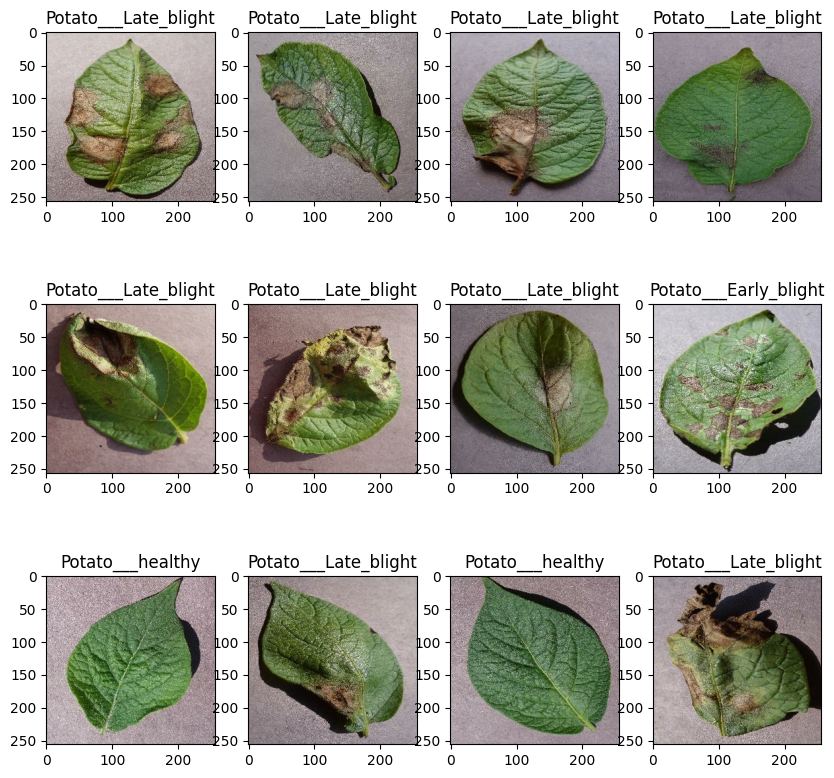

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [10]:
train_size=0.8 
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds=dataset.take(54)
len(train_ds)

54

In [12]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1 
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds=test_ds.take(6)
len(val_ds)


6

In [15]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
    

In [17]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [18]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
len(val_ds)


6

In [20]:
len(test_ds)

8

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [23]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
    
])
model.build(input_shape)

In [25]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'],
)

In [26]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 141s 2s/step - loss: 0.9112 - accuracy: 0.4855 - val_loss: 0.8239 - val_accuracy: 0.6198
Epoch 2/50
54/54 [==============================] - 123s 2s/step - loss: 0.7080 - accuracy: 0.6696 - val_loss: 0.6563 - val_accuracy: 0.6667
Epoch 3/50
54/54 [==============================] - 125s 2s/step - loss: 0.5083 - accuracy: 0.7836 - val_loss: 0.4605 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 124s 2s/step - loss: 0.3326 - accuracy: 0.8669 - val_loss: 0.4087 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 115s 2s/step - loss: 0.2721 - accuracy: 0.8953 - val_loss: 0.2865 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 125s 2s/step - loss: 0.2461 - accuracy: 0.9016 - val_loss: 0.3669 - val_accuracy: 0.8594
Epoch 7/50
54/54 [==============================] - 120s 2s/step - loss: 0.2334 - accuracy: 0.9155 - val_loss: 0.3133 - val_accuracy: 0.8802
Epoch 8/50
54

In [27]:
model.evaluate(test_ds)

8/8 [==============================] - 6s 544ms/step - loss: 0.0672 - accuracy: 0.9766


[0.06722432374954224, 0.9765625]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

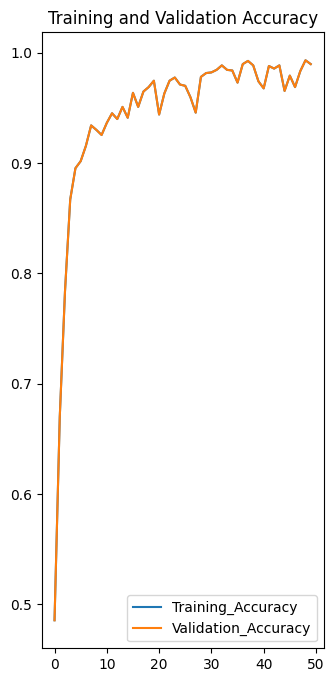

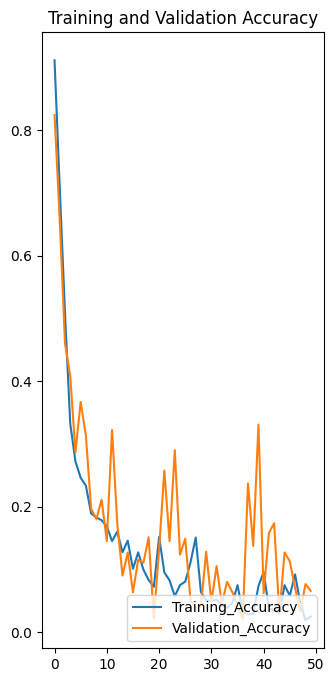

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training_Accuracy')
plt.plot(range(EPOCHS),acc,label='Validation_Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training_Accuracy')
plt.plot(range(EPOCHS),val_loss,label='Validation_Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

First image to predict
actual label is  Potato___Early_blight
1/1 [==============================] - 0s 394ms/step
predicted label is Potato___Early_blight


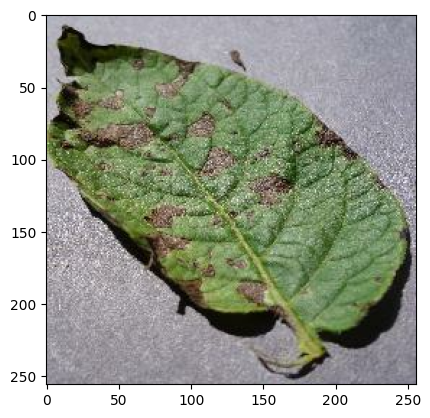

In [47]:
import numpy
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label is ",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print("predicted label is",class_names[numpy.argmax(batch_prediction[0])])
    

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[numpy.argmax(predictions[0])]
    confidence = round(100 * (numpy.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 66ms/step


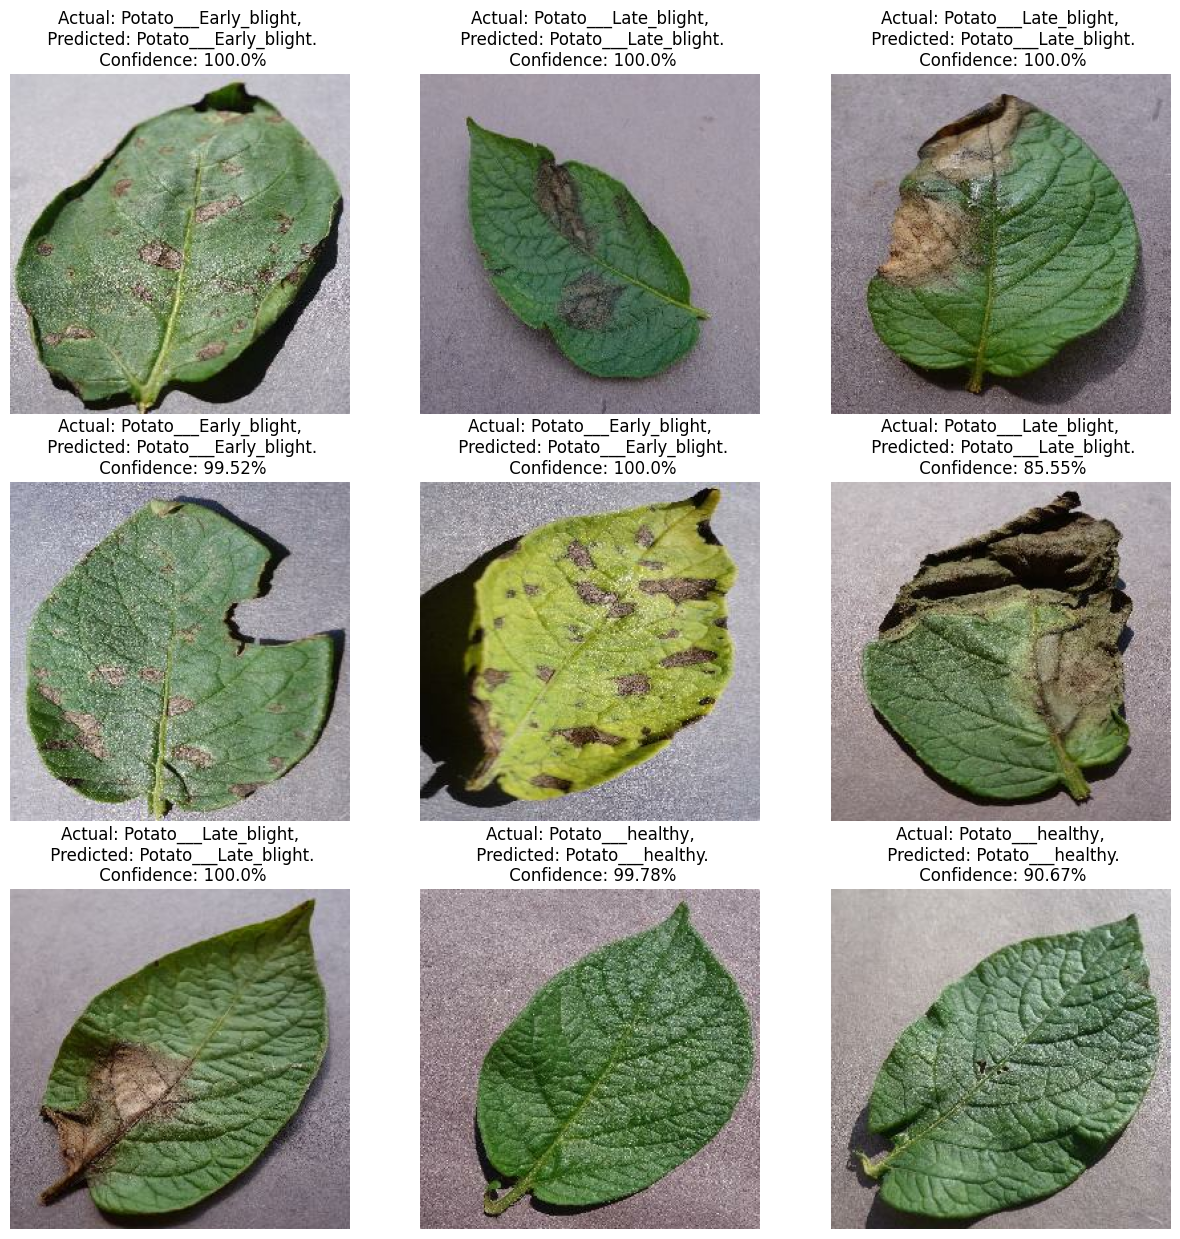

In [61]:
plt.figure(figsize=(15, 15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [62]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [63]:
model.save("../potatoes.h5")